In [117]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import mdirac as md

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-3-b00aa07ede3f>:112: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  csxv=np.zeros((circle.Np),dtype=np.complex)


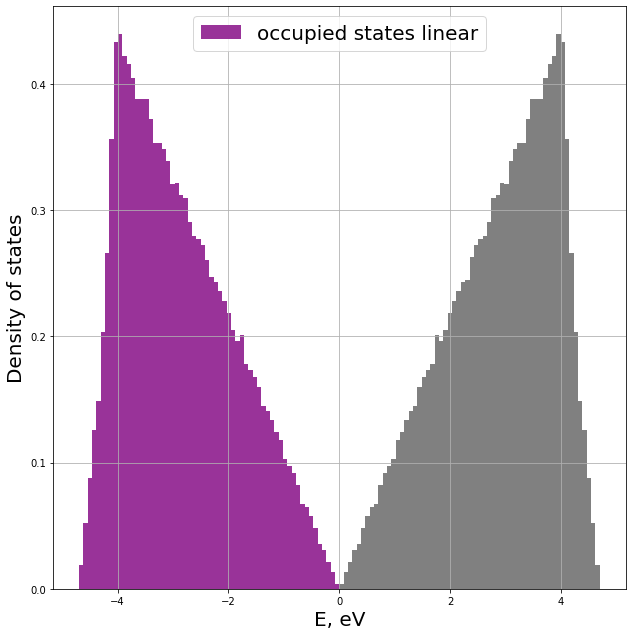

In [3]:
### graphene constants
gamma = 3 # hopping parameter in graphene
t = 2*np.pi*np.sqrt(3)/2*gamma # effective multiplier before dimensionless k*sigma in hamiltonian
deg = 4 # spin+valley degeneracy
###

### grid settings. scale 
kstep0 = 0.002
scale=0.5
cell=kstep0*np.array([[0.5*np.sqrt(3),0.5],[-0.5*np.sqrt(3),0.5]])
N = int(2/kstep0)
#kmesh = md.mesh.Parallelogram(N,cell)
#circle = kmesh.get_MBZ(scale=scale)
inds = np.arange(-N//2,N//2,1)
ii,jj=np.meshgrid(inds,inds,indexing='ij')
kmesh = np.tensordot(ii,cell[0],axes=0) + np.tensordot(jj,cell[1],axes=0)    
###

### system settings
def mkdir_p(mypath):
    from errno import EEXIST
    try:
        os.makedirs(mypath)
    except OSError as exc:
        if exc.errno == EEXIST and os.path.isdir(mypath):
            pass
        else: raise
path = 'out/mono_gr/gamma'+str(gamma)+'kstep0'+str(kstep0)+'contourplot'
mkdir_p(path)
###

### eigensystem writing
timelog = open(path+"/timelog.txt", "w")
startTime = time.time()
#E,U = md.mdirac.eighMesh(circle,t,'mono')
sx=np.array([[0,1],[1,0]])
sy=np.array([[0,-1.j],[1.j,0]])
ham = t*(np.tensordot(kmesh[:,:,0],sx,axes=0)+np.tensordot(kmesh[:,:,1],sy,axes=0))
E,U = np.linalg.eigh(ham)
executionTime = (time.time() - startTime)
timelog.write("Hamiltonian diagonalization time: " + str(executionTime) + '\n')

### dispersion curves plotting
Nst = 2/3
stepsGK = int(Nst/kstep0)
stepsKM = int(1/2*Nst/kstep0)
stepsMG = int(np.sqrt(3)/2*Nst/kstep0)

kGKx = 0
kGKy = -1*kstep0
kKMx = -0.5*np.sqrt(3)*kstep0
kKMy = 0.5*kstep0
kMGx = 0.5*kstep0
kMGy = 0.5*np.sqrt(3)*kstep0

kx = 0
ky = Nst

AllK = stepsGK+stepsKM+stepsMG
disp = np.zeros((AllK,2),float)

for i in np.arange(stepsGK):
    kx += kGKx
    ky += kGKy
    ham = md.MonolayerHamiltonian(kx,ky,t)
    eigenvalues = np.linalg.eigvalsh(ham)
    disp[i] = np.real(eigenvalues)

for i in np.arange(stepsGK,stepsGK+stepsKM):
    kx += kKMx
    ky += kKMy
    ham = md.MonolayerHamiltonian(kx,ky,t)
    eigenvalues = np.linalg.eigvalsh(ham)
    disp[i] = np.real(eigenvalues)

for i in np.arange(stepsGK+stepsKM,stepsGK+stepsKM+stepsMG):
    kx += kMGx
    ky += kMGy
    ham = md.MonolayerHamiltonian(kx,ky,t)
    eigenvalues = np.linalg.eigvalsh(ham)
    disp[i] = np.real(eigenvalues)


fig, ax = plt.subplots(figsize=(9,9))
for j in range(1,2):
    plt.plot(np.arange(AllK), disp[:,j], linestyle="-", linewidth=5,label='graphene linear model')
    
ax.set_ylabel('E, eV', fontsize=20)
plt.ylim(-0.1,10.5)
ax.grid()
ax.legend(loc='upper right', fontsize=20)
fig.tight_layout()
plt.xticks(np.array([0,stepsGK,stepsGK+stepsKM,stepsGK+stepsKM+stepsMG]),[r'$\Gamma$',"K","M",r'$\Gamma$'], fontsize=20)
plt.tight_layout()
plt.savefig(path+'/GKMG.png',dpi=180)
plt.close()

### DoS plotting
fig, ax = plt.subplots(figsize=(9,9))
ax.set_xlabel('E, eV', fontsize=20)
ax.set_ylabel('Density of states', fontsize=20)
ax.grid()
ax.legend(loc='upper right')
fig.tight_layout()
#plt.hist(E[:,0],bins='auto',density=True,color='#993399',label='occupied states linear')
#plt.hist(E[:,1],bins='auto',density=True,color='#808080')
plt.hist(E[:,:,0],bins='auto',density=True,color='#993399',label='occupied states linear')
plt.hist(E[:,:,1],bins='auto',density=True,color='#808080')
plt.legend(fontsize=20)
plt.savefig(path+'/dos.png',dpi=180)

### spectra writing parameters
#### omega is in units of eV 
bound = 3.5
scaleomega = 3.5/1000
omega=np.linspace(1.e-5,bound,1000) 
eta=1.5e-2
#factorsigma=-deg*kmesh.vcell*gamma**2*3/1.j 
#csxv=np.zeros((circle.Np),dtype=np.complex)
#dE=np.zeros((circle.Np),dtype=np.float64)
#sigma0=np.zeros((omega.shape[0]),dtype=np.complex128)
###

### calculation of spectra
dE = E[:,:,1]-E[:,:,0] # conduction minus valence band
dE[0,0]=dE[0,1]
#csxv = md.mdirac.cov_matrix_elements(sx,U,1,0)
#sigma0=md.mdirac.get_sigma_xx(factorsigma,omega+1.j*eta,dE,csxv)
alph = 1/137
lambd = 1240/omega # eV -> nm
d = 0.335 # graphene thickness, nm
eps = 1+1/2*alph*sigma0*lambd/d*1.j
###

### plotting results
def SigmaPlotter(left_cut, right_cut,scaleomega,omega,sigma): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    fig,ax=plt.subplots()
    ax.plot(scaleomega*omegas,
            np.real(sigma0[left_cut:right_cut]),
            c='y',label='monolayer graphene')
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.grid()
    ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
    ax.set_ylim([0.8,1.1])
    ax.legend(loc='upper right')
    fig.tight_layout()
    realsigmapath = path + '/realsigma'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(realsigmapath,dpi=180)
    plt.close()

def OptConstsPlotter(left_cut, right_cut,scaleomega,omega,eps): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    refr = np.sqrt(eps)[left_cut:right_cut]
    fig,ax=plt.subplots(dpi=180)
    ax.plot(scaleomega*omegas,refr.real,c='#6C09C9',label='n')
    ax.plot(scaleomega*omegas,refr.imag,c='g',label='k')
    ax.set_xlim([scaleomega*omegas[0],scaleomega*omegas[-1]])
    ax.set_ylim([0,np.max(refr.real)+1])
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.grid()
    ax.legend(loc='upper right')
    fig.tight_layout()
    optconstspath = path + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(optconstspath)
    conststofile = np.column_stack([omega[left_cut:right_cut], refr.real, refr.imag])
    np.savetxt(path+'/optconsts.txt',conststofile)
    plt.close()

SigmaPlotter(100,1000,scaleomega,omega,sigma0)
OptConstsPlotter(100,1000,scaleomega,omega,eps)
###


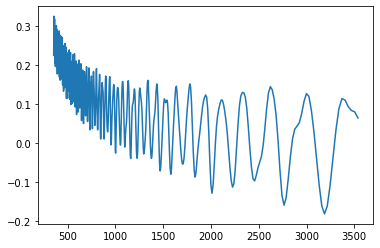

In [27]:
plt.plot(lambd[100:], sigma0.imag[100:])

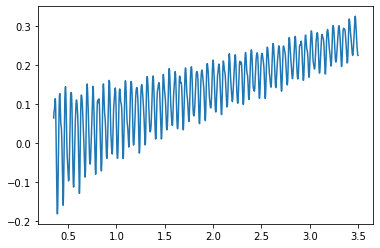

In [28]:
plt.plot(1240/lambd[100:], sigma0.imag[100:])

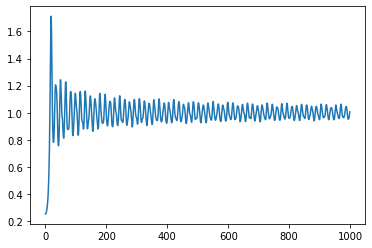

In [5]:
plt.plot(sigma0.real)

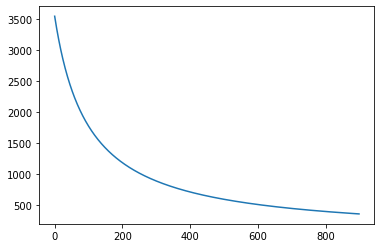

In [10]:
plt.plot(lambd[100:])

In [11]:
d

0.335

In [13]:
alph

0.0072992700729927005

In [48]:
beta = alph/2*lambd/d

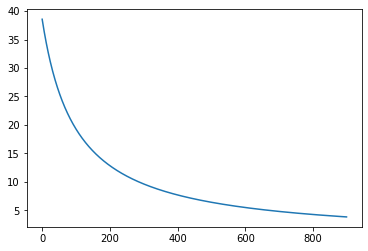

In [50]:
plt.plot(beta[100:])

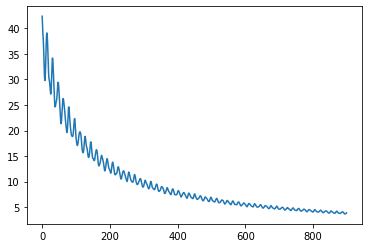

In [86]:
plt.plot(sigma0.real[100:]*beta[100:])

In [107]:
epscorr = 5 + 1.j*sigma0.real*beta

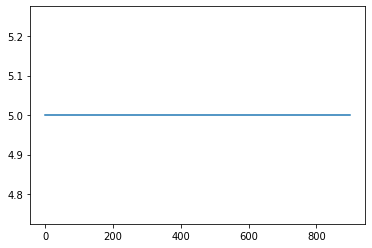

In [108]:
plt.plot(epscorr.real[100:])

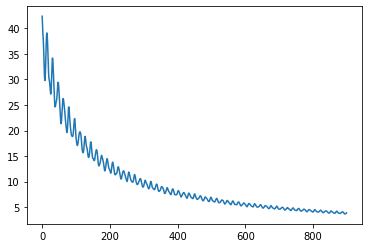

In [109]:
plt.plot(epscorr.imag[100:])

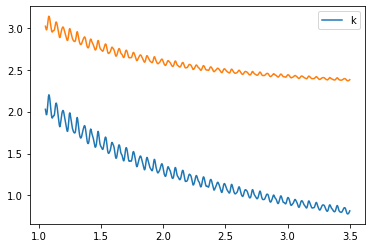

In [113]:
cutplot = 300
plt.plot(omega[cutplot:],np.sqrt(epscorr).imag[cutplot:],label='k')
plt.plot(omega[cutplot:],np.sqrt(epscorr).real[cutplot:])
plt.legend()

In [5]:
###
### calculation full nearest-neighbours hamiltonian for graphene 
###

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-25-b7463f07a1c8>:67: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  csxv=np.zeros((circle.Np),dtype=np.complex)


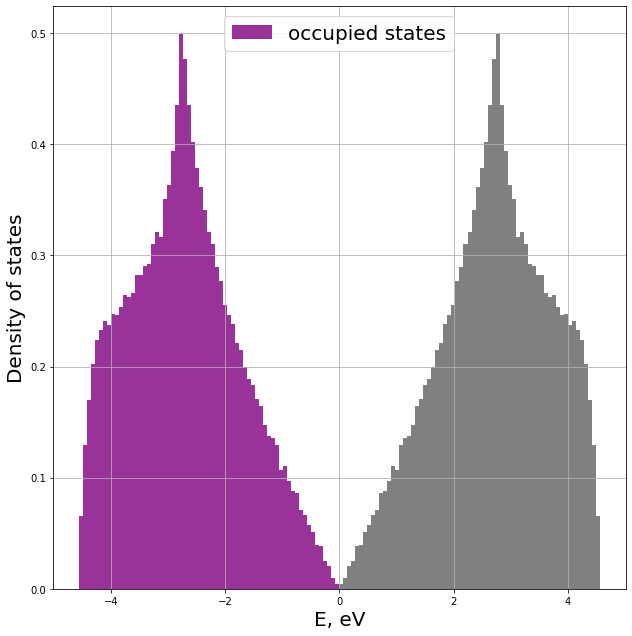

In [25]:
### graphene constants
gamma = 3 # hopping parameter in graphene
t = 2*np.pi*np.sqrt(3)/2*gamma # effective multiplier before dimensionless k*sigma in hamiltonian
deg = 4 # spin+valley degeneracy
###


### grid settings. scale 
kstep0 = 0.002
scale=0.5
cell=kstep0*np.array([[0.5*np.sqrt(3),0.5],[-0.5*np.sqrt(3),0.5]])
N = int(2/kstep0)
kmesh = md.mesh.Parallelogram(N,cell)
circle = kmesh.get_MBZ(scale=scale)
###

### system settings
def mkdir_p(mypath):
    from errno import EEXIST
    try:
        os.makedirs(mypath)
    except OSError as exc:
        if exc.errno == EEXIST and os.path.isdir(mypath):
            pass
        else: raise
path = 'out/mono_gr/gamma'+str(gamma)+'kstep0'+str(kstep0)+'prec'
mkdir_p(path)
###

### eigensystem writing
timelog = open(path+"/timelog.txt", "w")
startTime = time.time()
E,U = md.mdirac.eighMesh(circle,gamma,'mono_prec')
executionTime = (time.time() - startTime)
timelog.write("Hamiltonian diagonalization time: " + str(executionTime) + '\n')

### dispersion curves plotting
plt.plot(np.arange(E[:,1].shape[0]),E[:,1])
plt.savefig(path+'/disps_c.png',dpi=100)
plt.close()

plt.plot(np.arange(E[:,0].shape[0]),E[:,0])
plt.savefig(path+'/disps_v.png',dpi=100)
plt.close()

md.PlotGKMG(kstep0,gamma,'mono_prec',path)

### DoS plotting
fig, ax = plt.subplots(figsize=(9,9))
ax.set_xlabel('E, eV', fontsize=20)
ax.set_ylabel('Density of states', fontsize=20)
ax.grid()
ax.legend(loc='upper right')
fig.tight_layout()
plt.hist(E[:,0],bins='auto',density=True,color='#993399',label='occupied states')
plt.hist(E[:,1],bins='auto',density=True,color='#808080')
plt.legend(fontsize=20)
plt.savefig(path+'/dos.png',dpi=180)

### spectra writing parameters
#### omega is in units of eV 
bound = 3.5
scaleomega = 3.5/1000
omega=np.linspace(1.e-5,bound,1000) 
eta=1.5e-2
factorsigma=-deg*kmesh.vcell*gamma**2*3/1.j 
csxv=np.zeros((circle.Np),dtype=np.complex)
dE=np.zeros((circle.Np),dtype=np.float64)
sigma0=np.zeros((omega.shape[0]),dtype=np.complex128)
###

### calculation of spectra
dE = E[:,1]-E[:,0] # conduction minus valence band
dE[0]=dE[1]
sx=np.array([[0,1],[1,0]])
csxv = md.mdirac.cov_matrix_elements(sx,U,1,0)
sigma0=md.mdirac.get_sigma_xx(factorsigma,omega+1.j*eta,dE,csxv)
alph = 1/137
lambd = 1240/omega # eV -> nm
d = 0.335 # graphene thickness, nm
eps = 1+1/2*alph*sigma0*lambd/d*1.j
###

### plotting results
def SigmaPlotter(left_cut, right_cut,scaleomega,omega,sigma): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    fig,ax=plt.subplots()
    ax.plot(scaleomega*omegas,
            np.real(sigma0[left_cut:right_cut]),
            c='y',label='monolayer graphene')
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.grid()
    ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
    ax.set_ylim([0.8,1.1])
    ax.legend(loc='upper right')
    fig.tight_layout()
    realsigmapath = path + '/realsigma'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(realsigmapath,dpi=180)
    plt.close()

def OptConstsPlotter(left_cut, right_cut,scaleomega,omega,eps): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    refr = np.sqrt(eps)[left_cut:right_cut]
    fig,ax=plt.subplots(dpi=180)
    ax.plot(scaleomega*omegas,refr.real,c='#6C09C9',label='n')
    ax.plot(scaleomega*omegas,refr.imag,c='g',label='k')
    ax.set_xlim([scaleomega*omegas[0],scaleomega*omegas[-1]])
    ax.set_ylim([0,np.max(refr.real)+1])
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.grid()
    ax.legend(loc='upper right')
    fig.tight_layout()
    optconstspath = path + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(optconstspath)
    conststofile = np.column_stack([omega[left_cut:right_cut], refr.real, refr.imag])
    np.savetxt(path+'/optconsts.txt',conststofile)
    plt.close()

SigmaPlotter(100,1000,scaleomega,omega,sigma0)
OptConstsPlotter(100,1000,scaleomega,omega,eps)
###

In [26]:
###
### comparison of linear hamiltonian and nearest-neighbours hamiltonian for graphene
###

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-122-6b82ed128105>:127: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  csxv=np.zeros((circle.Np),dtype=np.complex)
<ipython-input-122-6b82ed128105>:130: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/de

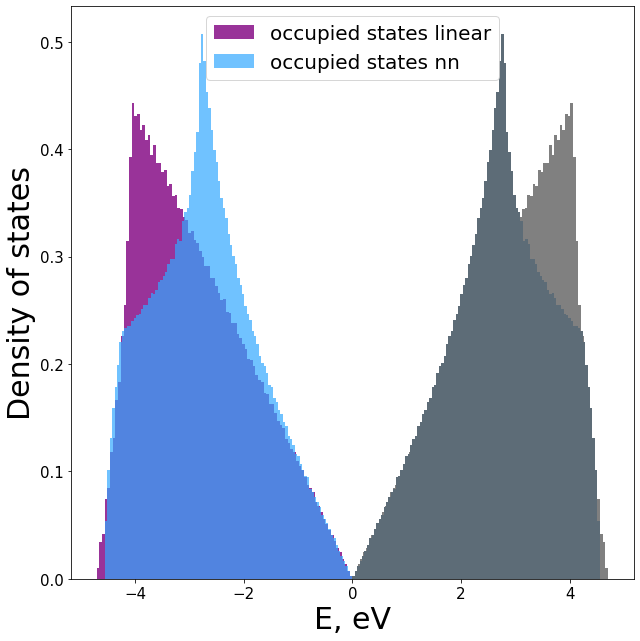

In [122]:
### graphene constants
gamma = 3 # hopping parameter in graphene
t = 2*np.pi*np.sqrt(3)/2*gamma # effective multiplier before dimensionless k*sigma in hamiltonian
deg = 4 # spin+valley degeneracy
###

### grid settings. scale 
kstep0 = 0.001
scale=0.5
cell=kstep0*np.array([[0.5*np.sqrt(3),0.5],[-0.5*np.sqrt(3),0.5]])
N = int(2/kstep0)
kmesh = md.mesh.Parallelogram(N,cell)
circle = kmesh.get_MBZ(scale=scale)
###

### system settings
def mkdir_p(mypath):
    from errno import EEXIST
    try:
        os.makedirs(mypath)
    except OSError as exc:
        if exc.errno == EEXIST and os.path.isdir(mypath):
            pass
        else: raise
path = 'out/mono_gr/gamma'+str(gamma)+'kstep0'+str(kstep0)+'comparison'
mkdir_p(path)
###

### eigensystem writing
timelog = open(path+"/timelog.txt", "w")
startTime = time.time()
E,U = md.mdirac.eighMesh(circle,t,'mono')
Efull, Ufull = md.mdirac.eighMesh(circle,gamma,'mono_prec')
executionTime = (time.time() - startTime)
timelog.write("Hamiltonian diagonalization time: " + str(executionTime) + '\n')

### dispersion curves plotting
Nst = 2/3
stepsGK = int(Nst/kstep0)
stepsKM = int(1/2*Nst/kstep0)
stepsMG = int(np.sqrt(3)/2*Nst/kstep0)

kGKx = 0
kGKy = -1*kstep0
kKMx = -0.5*np.sqrt(3)*kstep0
kKMy = 0.5*kstep0
kMGx = 0.5*kstep0
kMGy = 0.5*np.sqrt(3)*kstep0

kx = 0
ky = Nst

AllK = stepsGK+stepsKM+stepsMG
disp = np.zeros((AllK,2),float)
dispfull = np.zeros((AllK,2),float)

for i in np.arange(stepsGK):
    kx += kGKx
    ky += kGKy
    ham = md.MonolayerHamiltonian(kx,ky,t)
    eigenvalues = np.linalg.eigvalsh(ham)
    disp[i] = np.real(eigenvalues)
    ham = md.MonolayerHamiltonianPrecise(kx,ky,gamma)
    eigenvalues = np.linalg.eigvalsh(ham)
    dispfull[i] = np.real(eigenvalues)

for i in np.arange(stepsGK,stepsGK+stepsKM):
    kx += kKMx
    ky += kKMy
    ham = md.MonolayerHamiltonian(kx,ky,t)
    eigenvalues = np.linalg.eigvalsh(ham)
    disp[i] = np.real(eigenvalues)
    ham = md.MonolayerHamiltonianPrecise(kx,ky,gamma)
    eigenvalues = np.linalg.eigvalsh(ham)
    dispfull[i] = np.real(eigenvalues)

for i in np.arange(stepsGK+stepsKM,stepsGK+stepsKM+stepsMG):
    kx += kMGx
    ky += kMGy
    ham = md.MonolayerHamiltonian(kx,ky,t)
    eigenvalues = np.linalg.eigvalsh(ham)
    disp[i] = np.real(eigenvalues)
    ham = md.MonolayerHamiltonianPrecise(kx,ky,gamma)
    eigenvalues = np.linalg.eigvalsh(ham)
    dispfull[i] = np.real(eigenvalues)


fig, ax = plt.subplots(figsize=(9,9))
for j in range(1,2):
    plt.plot(np.arange(AllK), disp[:,j], linestyle="-", linewidth=5,label='graphene linear model')
    plt.plot(np.arange(AllK), dispfull[:,j], linestyle="-", linewidth=5,label='graphene nearest neighbs')
    
ax.set_ylabel('E, eV', fontsize=30)
plt.ylim(-0.1,10.5)
ax.legend(loc='upper right', fontsize=20)
fig.tight_layout()
plt.xticks(np.array([0,stepsGK,stepsGK+stepsKM,stepsGK+stepsKM+stepsMG]),[r'$\Gamma$',"K","M",r'$\Gamma$'], fontsize=40)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig(path+'/GKMG.png',dpi=180)
plt.close()

### DoS plotting
fig, ax = plt.subplots(figsize=(9,9))
ax.set_xlabel('E, eV', fontsize=30)
ax.set_ylabel('Density of states', fontsize=30)
ax.legend(loc='upper right')
fig.tight_layout()
plt.hist(E[:,0],bins='auto',density=True,color='#993399',label='occupied states linear')
plt.hist(Efull[:,0],bins='auto',density=True,color='#33A8FF',label='occupied states nn',alpha=0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(E[:,1],bins='auto',density=True,color='#808080')
plt.hist(Efull[:,1],bins='auto',density=True,color='#5D6C77')

plt.legend(fontsize=20)
plt.savefig(path+'/dos.png',dpi=180)


### spectra writing parameters
#### omega is in units of eV 
bound = 3.5
scaleomega = 3.5/1000
omega=np.linspace(1.e-5,bound,1000) 
eta=1.5e-2
factorsigma=-deg*kmesh.vcell*gamma**2*3/1.j 
csxv=np.zeros((circle.Np),dtype=np.complex)
dE=np.zeros((circle.Np),dtype=np.float64)
sigma0=np.zeros((omega.shape[0]),dtype=np.complex128)
csxvfull=np.zeros((circle.Np),dtype=np.complex)
dEfull=np.zeros((circle.Np),dtype=np.float64)
sigma0full=np.zeros((omega.shape[0]),dtype=np.complex128)
###

### calculation of spectra
dE = E[:,1]-E[:,0] # conduction minus valence band
dE[0]=dE[1]
sx=np.array([[0,1],[1,0]])
csxv = md.mdirac.cov_matrix_elements(sx,U,1,0)
sigma0=md.mdirac.get_sigma_xx(factorsigma,omega+1.j*eta,dE,csxv)

dEfull = Efull[:,1]-Efull[:,0] # conduction minus valence band
dEfull[0]=dEfull[1]
sx=np.array([[0,1],[1,0]])
csxvfull = md.mdirac.cov_matrix_elements(sx,Ufull,1,0)
sigma0full=md.mdirac.get_sigma_xx(factorsigma,omega+1.j*eta,dEfull,csxvfull)

alph = 1/137
lambd = 1240/omega # eV -> nm
d = 0.335 # graphene thickness, nm
eps = 1+1/2*alph*sigma0*lambd/d*1.j
epsfull = 1+1/2*alph*sigma0full*lambd/d*1.j
###

### plotting results
def SigmaPlotter(left_cut, right_cut,scaleomega,omega,sigma): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    fig,ax=plt.subplots()
    ax.plot(scaleomega*omegas,
            np.real(sigma0[left_cut:right_cut]),
            c='y',label='graphene linear model')
    ax.plot(scaleomega*omegas,
            np.real(sigma0full[left_cut:right_cut]),
            c='#1613CA',label='graphene nearest neighbs',alpha=0.7)
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.grid()
    ax.set_ylabel(r'Re $\sigma_{xx}$/$\sigma_0$',fontsize=15)
    ax.set_ylim([0.8,1.1])
    ax.legend(loc='upper right')
    fig.tight_layout()
    realsigmapath = path + '/realsigma'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(realsigmapath,dpi=180)
    plt.close()

def OptConstsPlotter(left_cut, right_cut,scaleomega,omega,eps): 
    omegas = np.arange(omega.shape[0])[left_cut:right_cut]
    refr = np.sqrt(eps)[left_cut:right_cut]
    refrfull = np.sqrt(epsfull)[left_cut:right_cut]
    fig,ax=plt.subplots(dpi=180)
    ax.plot(scaleomega*omegas,refr.real,c='#6C09C9',label='n linear model')
    ax.plot(scaleomega*omegas,refr.imag,c='g',label='k linear model')
    ax.plot(scaleomega*omegas,refrfull.real,c='#6C09C9',label='n nearest neighbs')
    ax.plot(scaleomega*omegas,refrfull.imag,c='g',label='k nearest neighbs')
    ax.set_xlim([scaleomega*omegas[0],scaleomega*omegas[-1]])
    ax.set_ylim([0,np.max(refr.real)+1])
    ax.set_xlabel(r'$\omega$, eV',fontsize=15)
    ax.grid()
    ax.legend(loc='upper right')
    fig.tight_layout()
    optconstspath = path + '/optconsts'+str(left_cut)+'_'+str(right_cut)+'.png'
    plt.savefig(optconstspath)
    conststofile = np.column_stack([omega[left_cut:right_cut], refr.real, refr.imag])
    np.savetxt(path+'/optconsts.txt',conststofile)
    plt.close()

SigmaPlotter(100,1000,scaleomega,omega,sigma0)
OptConstsPlotter(100,1000,scaleomega,omega,eps)
###

In [119]:
path

'out/mono_gr/gamma3kstep00.001comparison'

In [36]:
md.MonolayerHamiltonian(0,0,3).shape[0]

2

In [39]:
circle.cell

AttributeError: 'Circle' object has no attribute 'cell'

In [115]:
round(2.566)

3

In [116]:
np.random.rand(2,3)

array([[0.47368967, 0.68343468, 0.19128682],
       [0.85863441, 0.54920086, 0.05864467]])